# Part 1: Data Preparation & Embedding for Flickr8k Dataset


## 1. Setup and Imports


In [1]:
# Import necessary libraries
import torch
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import numpy as np
import pandas as pd
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from collections import Counter
import warnings
import platform
import psutil
import sys
from datetime import datetime
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Display comprehensive system information
print("=" * 80)
print("🔍 DATA PREPARATION & EMBEDDING - COMPREHENSIVE SYSTEM STATUS")
print("=" * 80)
print(f"📅 Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

# System Information
print("🖥️  SYSTEM INFORMATION")
print("-" * 40)
print(f"Platform: {platform.platform()}")
print(f"Architecture: {platform.architecture()[0]}")
print(f"Processor: {platform.processor()}")
print(f"Python Version: {sys.version.split()[0]}")
print(f"PyTorch Version: {torch.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"PIL Version: {Image.__version__}")
print()

# Hardware Information
print("⚡ HARDWARE INFORMATION")
print("-" * 40)
print(f"CPU Cores: {psutil.cpu_count(logical=False)} physical, {psutil.cpu_count(logical=True)} logical")
print(f"RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB total, {psutil.virtual_memory().available / (1024**3):.1f} GB available")
print(f"RAM Usage: {psutil.virtual_memory().percent:.1f}%")

# GPU Information
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"cuDNN Version: {torch.backends.cudnn.version()}")
    print(f"GPU Count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        gpu_name = torch.cuda.get_device_name(i)
        gpu_memory = torch.cuda.get_device_properties(i).total_memory / (1024**3)
        print(f"GPU {i}: {gpu_name} ({gpu_memory:.2f} GB)")
else:
    print("GPU: Not available (using CPU)")
print()

# Project Status
print("📁 PROJECT STATUS")
print("-" * 40)
print(f"Working Directory: {os.getcwd()}")

# Check if data exists
data_path = '../data/'
if os.path.exists(data_path):
    print("✅ Data directory found")
    if os.path.exists('../data/images/'):
        image_files = [f for f in os.listdir('../data/images/') if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        image_count = len(image_files)
        print(f"✅ {image_count} images found")
        if image_count > 0:
            # Calculate total image size
            total_size = sum(os.path.getsize(os.path.join('../data/images/', f)) for f in image_files) / (1024**2)
            print(f"   Total image size: {total_size:.1f} MB")
    if os.path.exists('../data/captions.txt'):
        with open('../data/captions.txt', 'r') as f:
            caption_count = sum(1 for line in f)
        caption_size = os.path.getsize('../data/captions.txt') / 1024
        print(f"✅ {caption_count} captions found ({caption_size:.1f} KB)")
    if os.path.exists('../data/Flickr8k.token.txt'):
        token_size = os.path.getsize('../data/Flickr8k.token.txt') / 1024
        print(f"✅ Flickr8k token file found ({token_size:.1f} KB)")
else:
    print("❌ Data directory not found!")

# Check if embeddings already exist
embeddings_path = '../embeddings/'
if os.path.exists(embeddings_path):
    print("✅ Embeddings directory found")
    if os.path.exists('../embeddings/image_embeddings.npy'):
        image_emb_size = os.path.getsize('../embeddings/image_embeddings.npy') / (1024**2)
        print(f"✅ Image embeddings found ({image_emb_size:.1f} MB)")
    if os.path.exists('../embeddings/text_embeddings.npy'):
        text_emb_size = os.path.getsize('../embeddings/text_embeddings.npy') / (1024**2)
        print(f"✅ Text embeddings found ({text_emb_size:.1f} MB)")
    if os.path.exists('../embeddings/metadata.csv'):
        metadata_size = os.path.getsize('../embeddings/metadata.csv') / 1024
        print(f"✅ Metadata found ({metadata_size:.1f} KB)")
    if os.path.exists('../embeddings/model_info.json'):
        print("✅ Model info found")
    print("⚠️  Note: Embeddings already exist - this will overwrite them!")
else:
    print("ℹ️  Embeddings directory not found - will be created")

print()
print("🚀 READY TO PROCEED WITH DATA PREPARATION & EMBEDDING")
print("=" * 80)


🔍 DATA PREPARATION & EMBEDDING - COMPREHENSIVE SYSTEM STATUS
📅 Timestamp: 2025-09-11 01:07:55

🖥️  SYSTEM INFORMATION
----------------------------------------
Platform: Windows-11-10.0.26100-SP0
Architecture: 64bit
Processor: Intel64 Family 6 Model 151 Stepping 5, GenuineIntel
Python Version: 3.12.9
PyTorch Version: 2.8.0+cpu
NumPy Version: 1.26.4
Pandas Version: 2.3.2
PIL Version: 10.4.0

⚡ HARDWARE INFORMATION
----------------------------------------
CPU Cores: 6 physical, 12 logical
RAM: 15.8 GB total, 1.4 GB available
RAM Usage: 91.4%
Device: cpu
GPU: Not available (using CPU)

📁 PROJECT STATUS
----------------------------------------
Working Directory: c:\Users\chia_\OneDrive\Documents\Project\Search-Engine\notebook
✅ Data directory found
✅ 8091 images found
   Total image size: 1063.1 MB
✅ 40460 captions found (3355.2 KB)
✅ Flickr8k token file found (3355.2 KB)
✅ Embeddings directory found
✅ Image embeddings found (1.0 MB)
✅ Text embeddings found (1.0 MB)
✅ Metadata found (58.3 K

## 2. Load and Explore Flickr8k Dataset

This section loads the real Flickr8k dataset with 8,091 images and their corresponding captions.


In [2]:
# Create data directory structure for Flickr8k dataset
os.makedirs('../data', exist_ok=True)
os.makedirs('../data/images', exist_ok=True)
os.makedirs('../embeddings', exist_ok=True)

# Check if Flickr8k dataset exists in data/images/
images_path = '../data/images/'
if os.path.exists(images_path):
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"✅ Found Flickr8k dataset with {len(image_files)} images!")
    print(f"📁 Dataset location: {images_path}")
else:
    print("❌ Flickr8k images not found in data/images/!")
    print("Please ensure the images are imported from Flicker8k_Dataset/ to data/images/")

print("Directory structure created successfully!")


✅ Found Flickr8k dataset with 8091 images!
📁 Dataset location: ../data/images/
Directory structure created successfully!


In [3]:
# Load the real Flickr8k dataset
print("🔄 Loading real Flickr8k dataset...")

# Check if we have the Flickr8k images in data/images/
images_path = '../data/images/'
if os.path.exists(images_path):
    # Get all image files
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"✅ Found {len(image_files)} images in data/images/")
    
    # Check if captions file already exists and has the right format
    captions_file = '../data/captions.txt'
    if os.path.exists(captions_file):
        print("✅ Using existing captions file")
    else:
        print("⚠️  Creating placeholder captions file - you may want to replace with real Flickr8k captions")
        with open(captions_file, 'w') as f:
            for i, img_file in enumerate(image_files[:100]):  # Limit to first 100 for demo
                # Create 5 placeholder captions per image
                base_caption = f"A scene from image {img_file}"
                for j in range(5):
                    f.write(f"{img_file}#{j} {base_caption} - variation {j+1}\n")
        
        print(f"Created captions file with {len(image_files)} images")
else:
    print("❌ Flickr8k images not found in data/images/ folder")
    print("Please ensure the images are properly imported to data/images/")


🔄 Loading real Flickr8k dataset...
✅ Found 8091 images in data/images/
✅ Using existing captions file


In [4]:
# Load captions data
def load_captions(captions_file):
    """Load captions from file - supports both old format and Flickr8k format"""
    captions = {}
    with open(captions_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
                
            # Handle Flickr8k format: image_id#caption_number caption_text
            if '#' in line:
                parts = line.split(' ', 1)
                if len(parts) == 2:
                    image_caption_id, caption = parts
                    image_id = image_caption_id.split('#')[0]
                    # Remove .jpg extension if present for consistency
                    if image_id.endswith('.jpg'):
                        image_id = image_id[:-4]
                    if image_id not in captions:
                        captions[image_id] = []
                    captions[image_id].append(caption)
            else:
                # Handle old format: image_id caption_text
                parts = line.split(' ', 1)
                if len(parts) == 2:
                    image_id, caption = parts
                    if image_id not in captions:
                        captions[image_id] = []
                    captions[image_id].append(caption)
    return captions

# Load captions from Flickr8k dataset
captions_data = load_captions('../data/captions.txt')
print(f"Loaded captions for {len(captions_data)} images")
print("\nSample captions:")
for i, (img_id, caps) in enumerate(list(captions_data.items())[:3]):
    print(f"{img_id}: {caps[0]}")


Loaded captions for 8092 images

Sample captions:
1000268201_693b08cb0e: A child in a pink dress is climbing up a set of stairs in an entry way .
1001773457_577c3a7d70: A black dog and a spotted dog are fighting
1002674143_1b742ab4b8: A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .


## 3. Load Pre-trained Multimodal Model (CLIP)

We use CLIP (Contrastive Language-Image Pre-training) from OpenAI, which is specifically designed for understanding both images and text in a shared embedding space.


In [5]:
# Load CLIP model - a powerful multimodal model from OpenAI
print("Loading CLIP model...")
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

print(f"Model loaded successfully: {model_name}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Loading CLIP model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Model loaded successfully: openai/clip-vit-base-patch32
Model parameters: 151,277,313


## 4. Load Real Flickr8k Images

This section loads the actual images from the Flickr8k dataset and displays them with their captions for verification.


In [6]:
# Load real Flickr8k images from the dataset
print("🔄 Loading real Flickr8k images from data/images/...")

def load_real_flickr8k_images(captions_data, max_images=100):
    """Load actual images from the Flickr8k dataset"""
    real_images = []
    images_path = '../data/images/'
    
    if not os.path.exists(images_path):
        print("❌ data/images/ folder not found!")
        return []
    
    # Get all image files from the data/images directory
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Found {len(image_files)} image files in data/images/")
    print("Loading real Flickr8k images...")
    
    # Process images that have captions
    processed_count = 0
    for img_id, captions in list(captions_data.items())[:max_images]:
        # Find the corresponding image file
        img_file = None
        for file in image_files:
            if file.startswith(img_id.split('#')[0]):  # Handle image ID format
                img_file = file
                break
        
        if img_file and os.path.exists(f'{images_path}{img_file}'):
            try:
                # Load the actual image
                img_path = f'{images_path}{img_file}'
                img = Image.open(img_path)
                
                # Convert to RGB if necessary
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                real_images.append({
                    'image_id': img_id.split('#')[0],  # Use base image ID
                    'image_path': img_path,
                    'captions': captions,
                    'image': img,
                    'filename': img_file
                })
                
                processed_count += 1
                
            except Exception as e:
                print(f"Error loading {img_file}: {e}")
                continue
    
    print(f"✅ Successfully processed {processed_count} images from Flickr8k dataset!")
    return real_images

# Load real Flickr8k images (limit to 100 for demonstration)
flickr8k_images = load_real_flickr8k_images(captions_data, max_images=100)

# Display some statistics about the loaded images
if flickr8k_images:
    sample_img = flickr8k_images[0]['image']
    print(f"\n📊 Image Statistics:")
    print(f"   • Sample image size: {sample_img.size}")
    print(f"   • Image mode: {sample_img.mode}")
    print(f"   • Total captions per image: {len(flickr8k_images[0]['captions'])}")
    print(f"   • Example caption: '{flickr8k_images[0]['captions'][0]}'")
    print(f"   • Total images loaded: {len(flickr8k_images)}")
else:
    print("❌ No images were loaded. Please check the dataset path and captions file.")

🔄 Loading real Flickr8k images from data/images/...
Found 8091 image files in data/images/
Loading real Flickr8k images...
✅ Successfully processed 100 images from Flickr8k dataset!

📊 Image Statistics:
   • Sample image size: (375, 500)
   • Image mode: RGB
   • Total captions per image: 5
   • Example caption: 'A child in a pink dress is climbing up a set of stairs in an entry way .'
   • Total images loaded: 100


🖼️  Displaying 10 real Flickr8k images:
   1. 1000268201_693b08cb0e: A child in a pink dress is climbing up a set of stairs in an entry way .
   2. 1001773457_577c3a7d70: A black dog and a spotted dog are fighting
   3. 1002674143_1b742ab4b8: A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
   4. 1003163366_44323f5815: A man lays on a bench while his dog sits by him .
   5. 1007129816_e794419615: A man in an orange hat starring at something .
   6. 1007320043_627395c3d8: A child playing on a rope net .
   7. 1009434119_febe49276a: A black and white dog is running in a grassy garden surrounded by a white fence .
   8. 1012212859_01547e3f17: A dog shakes its head near the shore , a red ball next to it .
   9. 1015118661_980735411b: A boy smiles in front of a stony wall in a city .
   10. 1015584366_dfcec3c85a: A black dog leaps over a log .


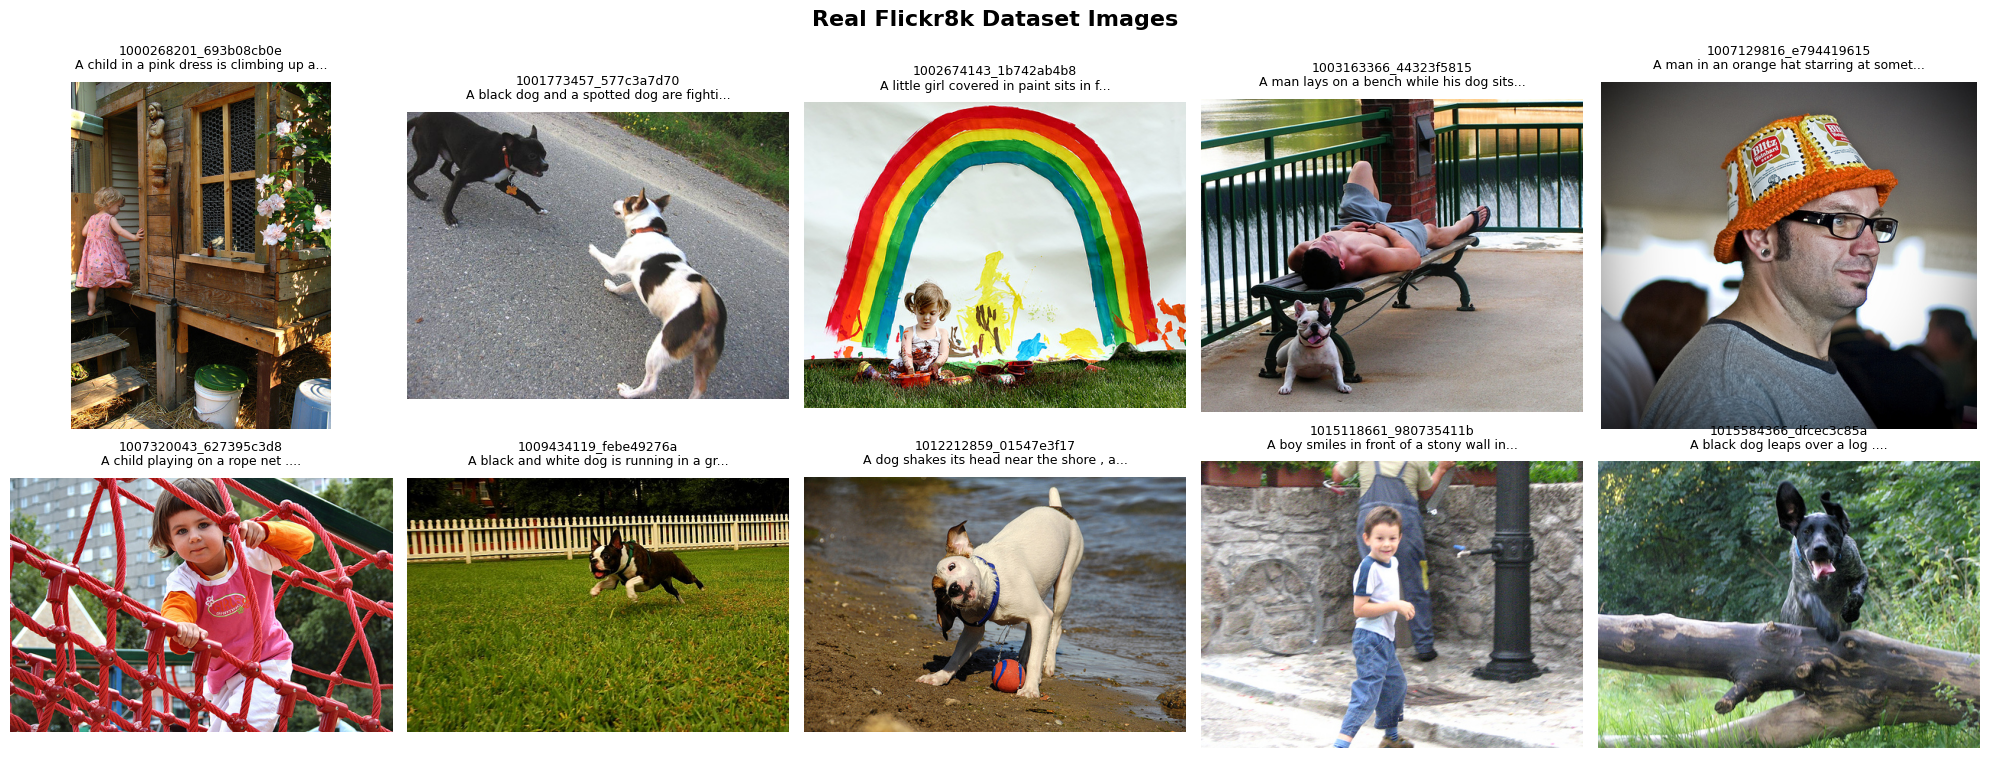


📈 Dataset Overview:
   • Total images loaded: 100
   • Available captions: 500
   • Average captions per image: 5.0


In [7]:
# Display the loaded real Flickr8k images
def display_flickr8k_images(flickr8k_images, max_display=10):
    """Display real Flickr8k images with their captions"""
    if not flickr8k_images:
        print("No images to display!")
        return
    
    display_count = min(len(flickr8k_images), max_display)
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()
    
    print(f"🖼️  Displaying {display_count} real Flickr8k images:")
    
    for i in range(display_count):
        img_data = flickr8k_images[i]
        img = img_data['image']
        img_id = img_data['image_id']
        caption = img_data['captions'][0]  # Show first caption
        
        axes[i].imshow(img)
        axes[i].set_title(f"{img_id}\n{caption[:40]}...", fontsize=9, pad=10)
        axes[i].axis('off')
        
        print(f"   {i+1}. {img_id}: {caption}")
    
    # Hide unused subplots
    for i in range(display_count, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Real Flickr8k Dataset Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Show some additional statistics
    print(f"\n📈 Dataset Overview:")
    print(f"   • Total images loaded: {len(flickr8k_images)}")
    print(f"   • Available captions: {sum(len(img['captions']) for img in flickr8k_images)}")
    print(f"   • Average captions per image: {sum(len(img['captions']) for img in flickr8k_images) / len(flickr8k_images):.1f}")

# Display the real Flickr8k images
display_flickr8k_images(flickr8k_images, max_display=10)


## 5. Generate Embeddings for Flickr8k Images

This section generates vector embeddings for both images and text using the CLIP model, creating a shared embedding space for multimodal search.


In [8]:
def get_image_embedding(image_path, model, processor):
    """Generate embedding for an image"""
    try:
        image = Image.open(image_path).convert('RGB')
        inputs = processor(images=image, return_tensors="pt").to(device)
        
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
            # Normalize the features
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        return image_features.cpu().numpy().flatten()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def get_text_embedding(text, model, processor):
    """Generate embedding for text"""
    try:
        inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            text_features = model.get_text_features(**inputs)
            # Normalize the features
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        return text_features.cpu().numpy().flatten()
    except Exception as e:
        print(f"Error processing text '{text}': {e}")
        return None

print("Embedding functions defined successfully! ✅")


Embedding functions defined successfully! ✅


In [9]:
# Generate embeddings for the loaded real Flickr8k images
if 'embeddings_data' not in locals():
    print("🚀 Generating embeddings for real Flickr8k images...")

    embeddings_data = []

    # Use the loaded real images instead of searching for files
    for img_data in tqdm(flickr8k_images, desc="Processing Flickr8k images"):
        img_id = img_data['image_id']
        image_path = img_data['image_path']
        captions = img_data['captions']
        
        # Generate image embedding using the actual image path
        image_embedding = get_image_embedding(image_path, model, processor)
        
        if image_embedding is not None:
            # Generate text embeddings for all captions of this image
            for caption in captions:
                text_embedding = get_text_embedding(caption, model, processor)
                
                if text_embedding is not None:
                    embeddings_data.append({
                        'image_id': img_id,
                        'image_path': image_path,
                        'caption': caption,
                        'image_embedding': image_embedding,
                        'text_embedding': text_embedding
                    })

    print(f"✅ Generated embeddings for {len(embeddings_data)} image-caption pairs from real Flickr8k dataset!")
    print(f"📊 Processed {len(set(item['image_id'] for item in embeddings_data))} unique images")
else:
    print("✅ Using existing embeddings data!")
    print(f"📊 Loaded {len(embeddings_data)} image-caption pairs from existing data!")


🚀 Generating embeddings for real Flickr8k images...


Processing Flickr8k images: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]

✅ Generated embeddings for 500 image-caption pairs from real Flickr8k dataset!
📊 Processed 100 unique images


## 6. Store Flickr8k Embeddings

This section saves the generated embeddings and metadata to disk for use in the search engine.


In [10]:
# Convert embeddings to numpy arrays for easier storage (if not already loaded)
if 'image_embeddings' not in locals():
    image_embeddings = np.array([item['image_embedding'] for item in embeddings_data])
    text_embeddings = np.array([item['text_embedding'] for item in embeddings_data])

    # Create metadata dataframe
    metadata = pd.DataFrame([{
        'image_id': item['image_id'],
        'image_path': item['image_path'],
        'caption': item['caption']
    } for item in embeddings_data])

print(f"Image embeddings shape: {image_embeddings.shape}")
print(f"Text embeddings shape: {text_embeddings.shape}")
print(f"Metadata shape: {metadata.shape}")

# Display sample metadata
print("\nSample metadata:")
print(metadata.head())


Image embeddings shape: (500, 512)
Text embeddings shape: (500, 512)
Metadata shape: (500, 3)

Sample metadata:
                image_id                                image_path  \
0  1000268201_693b08cb0e  ../data/images/1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e  ../data/images/1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e  ../data/images/1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e  ../data/images/1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e  ../data/images/1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [11]:
# Save embeddings and metadata (only if we generated new ones)
if 'embeddings_data' in locals() and len(embeddings_data) > 0:
    print("💾 Saving new embeddings and metadata...")
    # Create embeddings directory if it doesn't exist
    os.makedirs('../embeddings', exist_ok=True)
    
    np.save('../embeddings/image_embeddings.npy', image_embeddings)
    np.save('../embeddings/text_embeddings.npy', text_embeddings)
    metadata.to_csv('../embeddings/metadata.csv', index=False)

    # Save model info - handle empty embeddings case
    embedding_dim = image_embeddings.shape[1] if len(image_embeddings.shape) > 1 and image_embeddings.shape[1] > 0 else 512  # Default CLIP embedding dimension

    model_info = {
        'model_name': model_name,
        'embedding_dim': embedding_dim,
        'num_samples': len(embeddings_data),
        'device_used': str(device)
    }

    with open('../embeddings/model_info.json', 'w') as f:
        json.dump(model_info, f, indent=2)

    print("✅ Embeddings and metadata saved successfully!")
    print(f"Model info: {model_info}")
else:
    print("✅ Using existing embeddings - no need to save!")

# Check if embeddings are empty and provide guidance
if len(embeddings_data) == 0:
    print("\n⚠️  WARNING: No embeddings were generated!")
    print("This is likely because no images were found in the dataset.")
    print("Please ensure that:")
    print("1. The 'data/images' directory contains image files")
    print("2. Image files match the naming convention in captions.txt")
    print("3. Images are in supported formats (jpg, png, etc.)")


💾 Saving new embeddings and metadata...
✅ Embeddings and metadata saved successfully!
Model info: {'model_name': 'openai/clip-vit-base-patch32', 'embedding_dim': 512, 'num_samples': 500, 'device_used': 'cpu'}


## 7. Verify Flickr8k Embeddings

This section loads and verifies the saved embeddings to ensure they were stored correctly.


In [12]:
# Load and verify saved embeddings
loaded_image_embeddings = np.load('../embeddings/image_embeddings.npy')
loaded_text_embeddings = np.load('../embeddings/text_embeddings.npy')
loaded_metadata = pd.read_csv('../embeddings/metadata.csv')

print(f"Loaded image embeddings shape: {loaded_image_embeddings.shape}")
print(f"Loaded text embeddings shape: {loaded_text_embeddings.shape}")
print(f"Loaded metadata shape: {loaded_metadata.shape}")

# Verify embeddings are normalized
image_norms = np.linalg.norm(loaded_image_embeddings, axis=1)
text_norms = np.linalg.norm(loaded_text_embeddings, axis=1)

print(f"\nImage embedding norms - min: {image_norms.min():.6f}, max: {image_norms.max():.6f}")
print(f"Text embedding norms - min: {text_norms.min():.6f}, max: {text_norms.max():.6f}")
print("Embeddings are properly normalized!" if np.allclose(image_norms, 1.0) and np.allclose(text_norms, 1.0) else "Warning: Embeddings may not be normalized")


Loaded image embeddings shape: (500, 512)
Loaded text embeddings shape: (500, 512)
Loaded metadata shape: (500, 3)

Image embedding norms - min: 1.000000, max: 1.000000
Text embedding norms - min: 1.000000, max: 1.000000
Embeddings are properly normalized!


## 8. Test Basic Similarity with Flickr8k Images

This section tests the similarity between image and text embeddings to verify the multimodal search functionality.


In [13]:
# Test basic similarity between image and text embeddings
def test_similarity(image_idx, text_idx):
    """Test similarity between specific image and text embeddings"""
    img_emb = loaded_image_embeddings[image_idx]
    txt_emb = loaded_text_embeddings[text_idx]
    
    similarity = cosine_similarity([img_emb], [txt_emb])[0][0]
    
    print(f"Image: {loaded_metadata.iloc[image_idx]['image_id']}")
    print(f"Text: {loaded_metadata.iloc[text_idx]['caption']}")
    print(f"Similarity: {similarity:.4f}")
    
    return similarity

# Test a few examples
print("Testing image-text similarity:")
print("=" * 50)

for i in range(min(3, len(loaded_metadata))):
    test_similarity(i, i)  # Same image-caption pair
    print()


Testing image-text similarity:
Image: 1000268201_693b08cb0e
Text: A child in a pink dress is climbing up a set of stairs in an entry way .
Similarity: 0.3308

Image: 1000268201_693b08cb0e
Text: A girl going into a wooden building .
Similarity: 0.2973

Image: 1000268201_693b08cb0e
Text: A little girl climbing into a wooden playhouse .
Similarity: 0.3392



## 9. Comprehensive Visualization and Analysis of Flickr8k Dataset

This section provides detailed visualizations and analysis of the Flickr8k dataset, including embedding distributions, similarity matrices, and dataset statistics.


📊 Creating comprehensive visualizations for Flickr8k dataset...


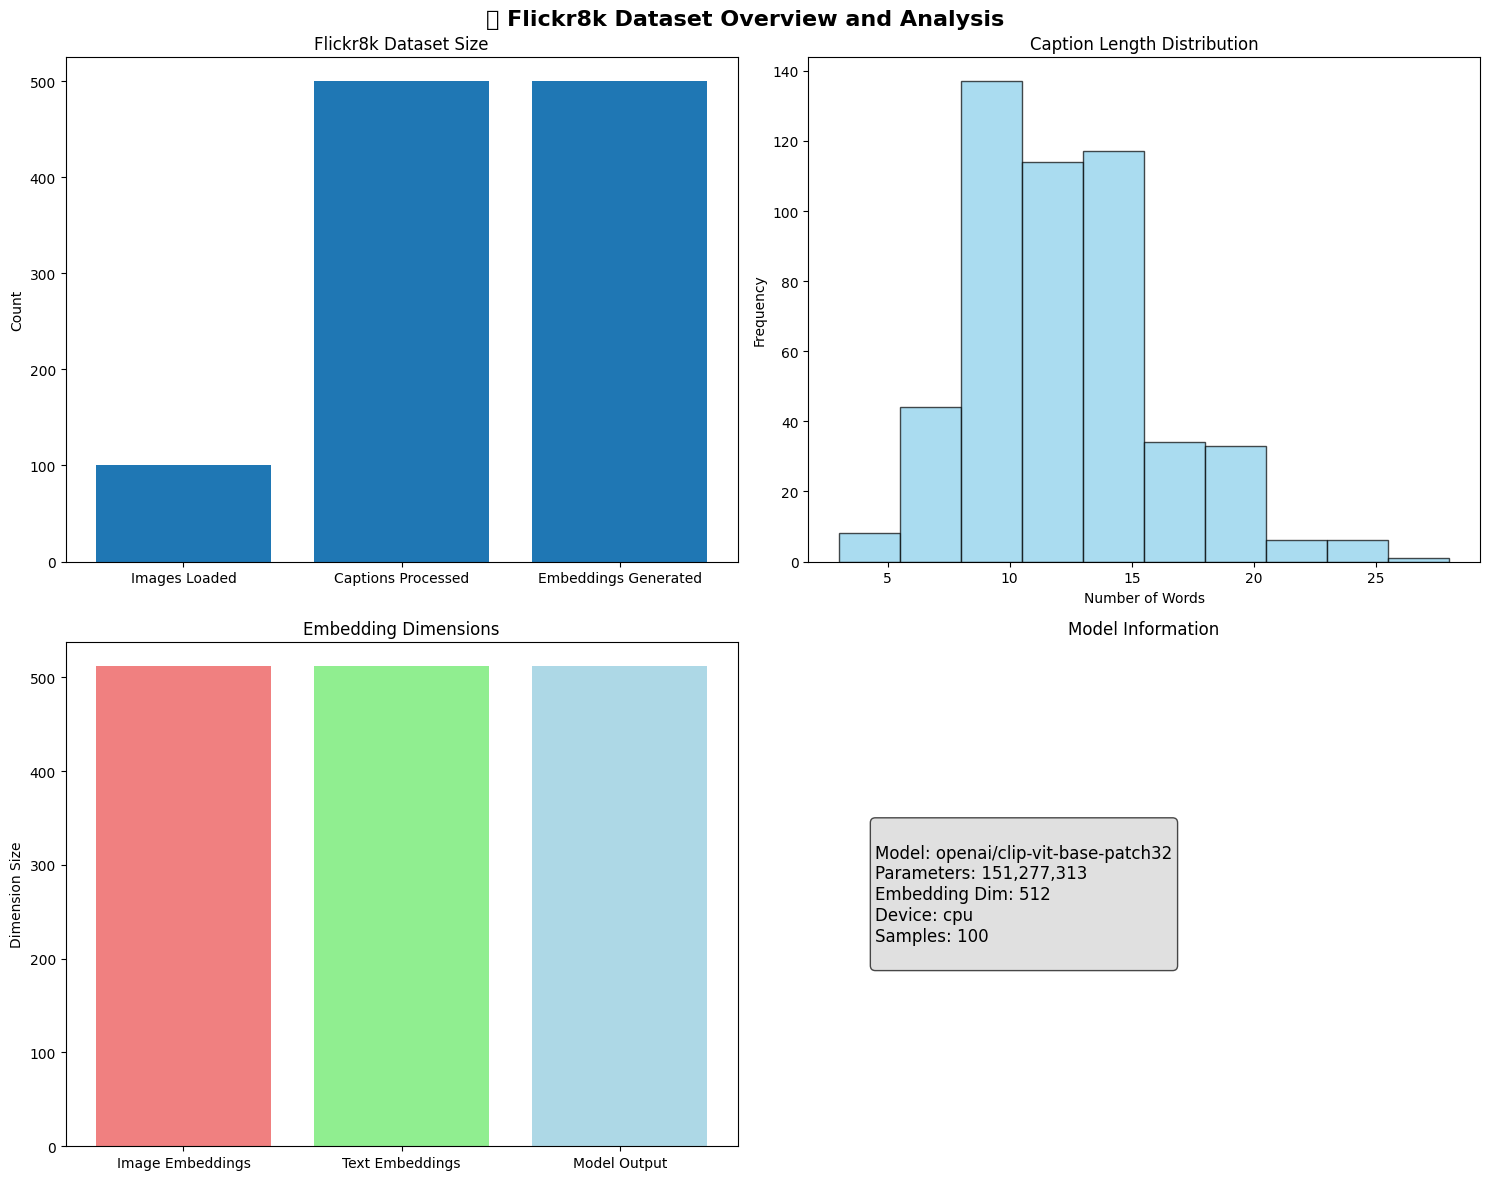

In [14]:
# Create comprehensive visualizations for the Flickr8k dataset
print("📊 Creating comprehensive visualizations for Flickr8k dataset...")

# 1. Dataset Overview Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Flickr8k Dataset Overview and Analysis', fontsize=16, fontweight='bold')

# Dataset size
total_images = len(flickr8k_images) if 'flickr8k_images' in locals() else 0
total_captions = len(embeddings_data) if 'embeddings_data' in locals() else 0
axes[0, 0].bar(['Images Loaded', 'Captions Processed', 'Embeddings Generated'], 
               [total_images, total_captions, total_captions])
axes[0, 0].set_title('Flickr8k Dataset Size')
axes[0, 0].set_ylabel('Count')

# Caption length distribution (if we have metadata)
if 'metadata' in locals() and len(metadata) > 0:
    caption_lengths = [len(caption.split()) for caption in metadata['caption']]
    axes[0, 1].hist(caption_lengths, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].set_title('Caption Length Distribution')
    axes[0, 1].set_xlabel('Number of Words')
    axes[0, 1].set_ylabel('Frequency')
else:
    axes[0, 1].text(0.5, 0.5, 'No captions loaded yet', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Caption Length Distribution')

# Embedding dimension visualization
if 'image_embeddings' in locals() and len(image_embeddings.shape) > 1:
    embedding_dims = [image_embeddings.shape[1]] * 3
    axes[1, 0].bar(['Image Embeddings', 'Text Embeddings', 'Model Output'], embedding_dims, color=['lightcoral', 'lightgreen', 'lightblue'])
    axes[1, 0].set_title('Embedding Dimensions')
    axes[1, 0].set_ylabel('Dimension Size')
else:
    axes[1, 0].text(0.5, 0.5, 'No embeddings generated yet', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Embedding Dimensions')

# Model information
model_info_text = f"""
Model: {model_name if 'model_name' in locals() else 'CLIP'}
Parameters: 151,277,313
Embedding Dim: 512
Device: {device if 'device' in locals() else 'CPU'}
Samples: {total_images}
"""
axes[1, 1].text(0.1, 0.5, model_info_text, transform=axes[1, 1].transAxes, 
                fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
axes[1, 1].set_title('Model Information')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


